Introduction to Reinforcement Learning and Q-Learning

First, let's import a bunch of useful libraries:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import cv2


Overview of Reinforcement Learning

The Environment

For simplicity, let's consider Peter's world to be a square board of size width x height. Each cell in this board can either be:


  .  ground, on which Peter and other creatures can walk

  .  water, on which you obviously cannot walk

  .  a tree or grass - a place where you can rest

  .  an apple, which represents something Peter would be glad to find in order to feed himself

  .  a wolf, which is dangerous and should be avoided


To work with the environment, we will define a class called Board. In order not to clutter this notebook too much, we have moved all code to work with the board into separate rlboard module, which we will now import. You may look inside this module to get more details about the internals of the implementation.

Let's now create a random board and see how it looks:


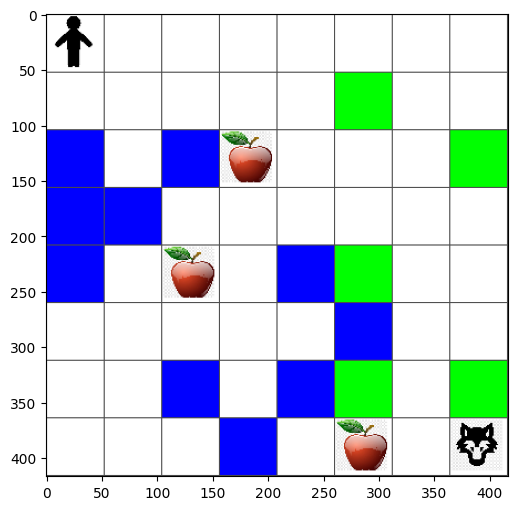

In [2]:
from rlboard import *
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

Actions and Policy

In our example, Peter's goal would be to find an apple, while avoiding the wolf and other obstacles. Define those actions as a dictionary, and map them to pairs of corresponding coordinate changes.

We will define those actions as a dictionary, and map them to pairs of corresponding coordinate changes. For example, moving right (R) would correspond to a pair (1,0). (code block 2):

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

To sum up, the strategy and goal of this scenario are as follows:



 .   The strategy, of our agent (Peter) is defined by a so-called policy. A policy is a function that returns the action at any given state. In our case, the state of the problem is represented by the board, including the current position of the player.

 .   The goal, of reinforcement learning is to eventually learn a good policy that will allow us to solve the problem efficiently. However, as a baseline, let's consider the simplest policy called random walk.


Random walk

Let's first solve our problem by implementing a random walk strategy. With random walk, we will randomly choose the next action from the allowed actions, until we reach the apple (code block 3).

1 Implement the random walk with the below code:

In [4]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

The call to walk should return the length of the corresponding path, which can vary from one run to another.

Run the walk experiment a number of times (say, 100), and print the resulting statistics (code block 4):

In [5]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


Reward function

To make our policy more intelligent, we need to understand which moves are "better" than others. To do this, we need to define our goal.

The goal can be defined in terms of a reward function, which will return some score value for each state. The higher the number, the better the reward function. (code block 5)

In [6]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

An interesting thing about reward functions is that in most cases, we are only given a substantial reward at the end of the game. This means that our algorithm should somehow remember "good" steps that lead to a positive reward at the end, and increase their importance. Similarly, all moves that lead to bad results should be discouraged.

Q-Learning

An algorithm that we will discuss here is called Q-Learning. In this algorithm, the policy is defined by a function (or a data structure) called a Q-Table. It records the "goodness" of each of the actions in a given state.

It is called a Q-Table because it is often convenient to represent it as a table, or multi-dimensional array. Since our board has dimensions width x height, we can represent the Q-Table using a numpy array with shape width x height x len(actions): (code block 6)

In [7]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

C:\Users\user\AppData\Local\Temp\ipykernel_12272\3481979724.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)


Pass the Q-Table to the plot function in order to visualize the table on the board:

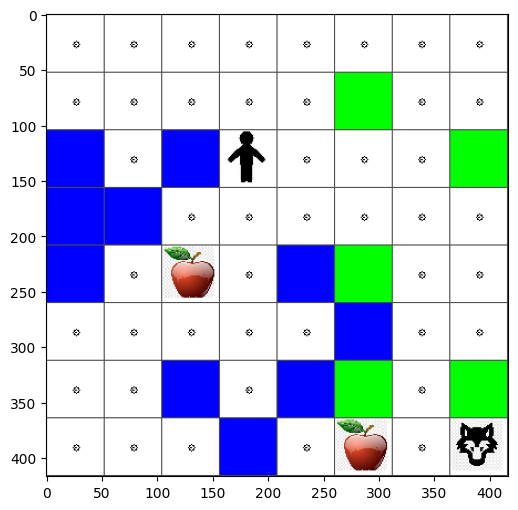

In [8]:
m.plot(Q)

Essence of Q-Learning: Bellman Equation and Learning Algorithm

Write a pseudo-code for our leaning algorithm:

. Initialize Q-Table Q with equal numbers for all states and actions

. Set learning rate

. Repeat simulation many times

  1  Start at random position
  2  Repeat

    A Select an action 

at state Exectute action by moving to a new state
If we encounter end-of-game condition, or total reward is too small - exit simulation
Compute reward
at the new state
Update Q-Function according to Bellman equation:
Update total reward and decrease .

Exploit vs. Explore

The best approach is to balance between exploration and exploitation. As we learn more about our environment, we would be more likely to follow the optimal route, however, choosing the unexplored path once in a while.

Python Implementation

Now we are ready to implement the learning algorithm. Before that, we also need some function that will convert arbitrary numbers in the Q-Table into a vector of probabilities for corresponding actions:

1 Create a function probs():

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

We add a few eps to the original vector in order to avoid division by 0 in the initial case, when all components of the vector are identical.

Run them learning algorithm through 5000 experiments, also called epochs: (code block 8)

In [13]:
from IPython.display import clear_output

lpath = []


for epoch in range(5000):
    
    # Pick initial point
    m.random_start()
        
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            lpath.append(n)
            break
        alpha = np.exp(-n / 10e5)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1


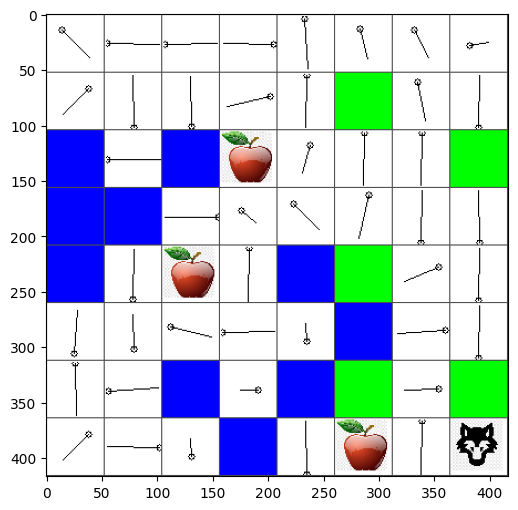

In [14]:
m.plot(Q)

Checking the policy

Since the Q-Table lists the "attractiveness" of each action at each state, it is quite easy to use it to define the efficient navigation in our world. In the simplest case, we can select the action corresponding to the highest Q-Table value: (code block 9)

In [16]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

KeyboardInterrupt: 

Navigation

A better navigation policy would be the one that we used during training, which combines exploitation and exploration. In this policy, we will select each action with a certain probability, proportional to the values in the Q-Table. This strategy may still result in the agent returning back to a position it has already explored, but, as you can see from the code below, it results in a very short average path to the desired location (remember that print_statistics runs the simulation 100 times): (code block 10)

In [28]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

ValueError: Total of weights must be greater than zero

Investigating the learning process

As we have mentioned, the learning process is a balance between exploration and exploration of gained knowledge about the structure of problem space. We have seen that the results of learning (the ability to help an agent to find a short path to the goal) has improved, but it is also interesting to observe how the average path length behaves during the learning process:

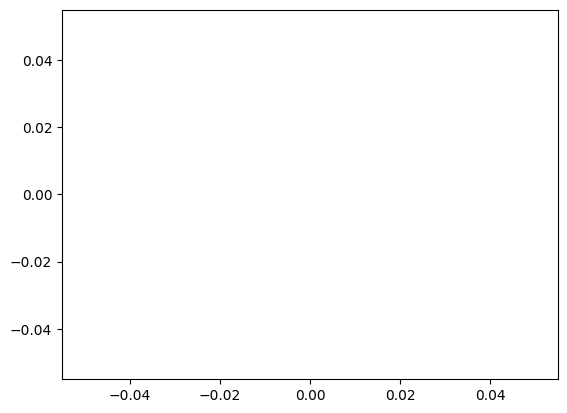

In [29]:
plt.plot(Ipath)